This is an experimental script to try out different normalization methods for the visual-haptic algorithm.

In [12]:
#!/usr/bin/env python3

"""This script processes input video through the visual-haptic algorithm.

NOTE: Work in progress!"""

###### USER SETTINGS ######
VIDEO = "truck" # pick video suffix from algo_input_videos/ folder
RESOLUTION_ATT = 100 # resolution of get_attention for DINO model
MODEL = 'hybrid' # MiDaS model type ('small', 'hybrid', 'large')
THRESHOLD_VAL = 0.35 # threshold of attention+depth combination
BIAS = 0.75 # bias towards attention for attention+depth combination
SCALE = 4 # scaling of combined array (scale*[16, 9])
DISPLAY_DIMS = (4,7) # HASEL haptic display dimensions, H x W (pixels)
FRAME_SKIP = 5 # interval for how often to calculate algorithm (then interpolate between)
FRAME_RATE = 30 # video frame rate (must check video properties!!)
# note on FRAME_SKIP: only needed when you want fast processing time. Otherwise set to 0.
DEVICE = "cpu"

###### INITIALIZATIONS ######
import matplotlib.pyplot as plt
import torch
import numpy as np
import cv2
import matplotlib.animation as animation
import sys  
sys.path.insert(1, '/haptic_utils/')
import haptic_utils.algo_preprocessing as algo

ModuleNotFoundError: No module named 'haptic_utils'

In [2]:

## Setting up torch device and model, video input
device = torch.device("cpu")
dino8 = torch.hub.load('facebookresearch/dino:main','dino_vits8')
dino8.to(device)
dino8.eval()
midas_h = torch.hub.load('intel-isl/MiDaS','DPT_Hybrid')
midas_l = torch.hub.load('intel-isl/MiDaS','DPT_Large')
midas_s = torch.hub.load('intel-isl/MiDaS','MiDaS_small')
midas_transforms = torch.hub.load('intel-isl/MiDaS','transforms')
midas_h.to(device)
midas_h.eval()
midas_l.to(device)
midas_l.eval()
midas_s.to(device)
midas_s.eval()
video = 'koi'
cap = cv2.VideoCapture("algo_input_videos/video_" + video + ".mp4") #use video

frame_num = 1
output_list = []
depth_list = []
attention_list = []

################## PARAMETERS ##################
RESOLUTION_ATT = 100 # resolution of get_attention for DINO model
MODEL = 'hybrid' # MiDaS model type ('small', 'hybrid', 'large')
THRESHOLD_VAL = 0.35 # threshold of attention+depth combination
BIAS = 0.75 # bias towards attention for attention+depth combination
SCALE = 4 # scaling of combined array (scale*[16, 9])
DISPLAY_W = 7 # HASEL haptic display width (pixels)
DISPLAY_H = 4 # HASEL haptic display height (pixels)
FRAME_SKIP = 5 # interval for how often to calculate algorithm (then interpolate between)

Using cache found in C:\Users\tempu/.cache\torch\hub\facebookresearch_dino_main
Using cache found in C:\Users\tempu/.cache\torch\hub\intel-isl_MiDaS_master
c:\Users\tempu\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\tempu\AppData\Local\Programs\Python\Python312\Lib\site-packages\timm\models\_factory.py:117: UserWarning: Mapping deprecated model name vit_base_resnet50_384 to current vit_base_r50_s16_384.orig_in21k_ft_in1k.
  model = create_fn(
Using cache found in C:\Users\tempu/.cache\torch\hub\intel-isl_MiDaS_master
Using cache found in C:\Users\tempu/.cache\torch\hub\intel-isl_MiDaS_master


Loading weights:  None


Using cache found in C:\Users\tempu/.cache\torch\hub\rwightman_gen-efficientnet-pytorch_master
Using cache found in C:\Users\tempu/.cache\torch\hub\intel-isl_MiDaS_master


In [6]:

################## FUNCTIONS ##################
# Grab video frame (next frame if frame_num=1 or nth frame if =n)
def grab_frame(source=cap):
    ret = source.grab()
    if ret is False: # if no data is available from the source, return Nones
        return None
    ret, frame = source.retrieve() # retrieve the desired frame from source
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # color conversion
    return frame

# Get self attention from video frame using DINO
def get_attention(frame):
    global RESOLUTION_ATT
    transform1 = transforms.Compose([           
                                transforms.Resize((RESOLUTION_ATT,int(np.floor(RESOLUTION_ATT*1.7777)))),
                                # transforms.CenterCrop(resolution), #should be multiple of model patch_size                 
                                transforms.ToTensor(),                    
                                #transforms.Normalize(mean=0.5, std=0.2)
                                ])
    frame_t = transform1(frame).unsqueeze(0)
    attentions = dino8.get_last_selfattention(frame_t)
    nh = attentions.shape[1]
    attentions = attentions[0, :, 0, 1:].reshape(nh,-1)
    patch_size = 4
    w_featmap = frame_t.shape[-2] // patch_size
    h_featmap = frame_t.shape[-1] // patch_size

    attentions = attentions.reshape(nh, w_featmap//2, h_featmap//2)
    attentions = nn.functional.interpolate(attentions.unsqueeze(0), scale_factor=1, mode="nearest")[0].detach().numpy()
    attentions_mean = (np.mean(attentions, axis=0))
    return attentions_mean

# get depth estimation of frame using MiDaS
def get_depth(img):
    global MODEL
    if MODEL == 'small':
        frame = midas_transforms.small_transform(img) # use small image transform
        depth_size_x = 256
        depth = midas_s(frame) # evaluate using small model
    else:
        frame = midas_transforms.dpt_transform(img) # use DPT image transform
        depth_size_x = 672
        if MODEL == 'hybrid':
            depth = midas_h(frame) # evaluate using hybrid model
        else:
            depth = midas_l(frame) # evaluate using large model

    depth = depth.cpu().detach().numpy().squeeze(0)
    
    # remove normal depth gradient from depth map
    # depth_nm = cv2.normalize(depth, None, 0, 1, norm_type=cv2.NORM_MINMAX, dtype = cv2.CV_64F)
    xgrid = np.zeros(depth_size_x, dtype=float)
    ygrid = depth.mean(axis=1) # make mean-depth-based gradient
    grad_array = np.meshgrid(xgrid, ygrid)[1] # form gradient array w/ same size as depth
    depth_sub = (depth - grad_array)
    depth_sub = (depth_sub > 0) * depth_sub # take only positive values

    return depth_sub

# combine depth and attention maps together
def get_combined(depth, attention, method='sum'):
    global BIAS
    global SCALE
    depth_re = cv2.resize(depth, dsize=(16*SCALE, 9*SCALE), interpolation=cv2.INTER_CUBIC)
    depth_nm = cv2.normalize(depth_re, None, 0, 1, norm_type=cv2.NORM_MINMAX, dtype = cv2.CV_64F)
    attention_re = cv2.resize(attention, dsize=(16*SCALE, 9*SCALE), interpolation=cv2.INTER_CUBIC)
    attention_nm = cv2.normalize(attention_re, None, 0, 1, norm_type=cv2.NORM_MINMAX, dtype = cv2.CV_64F)

    if method=='multiply':
        combined = depth_nm*attention_nm
    elif method=='sum':
        combined = ((1-BIAS)*depth_nm + (BIAS)*attention_nm)
    combined = cv2.normalize(combined, None, 0, 1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_64F)

    return combined

# threshold the combined map to threshold_val
def get_threshold(combined):
    global THRESHOLD_VAL
    return (combined > THRESHOLD_VAL) * combined

# downsample the thresholded map to the grid size of the haptic display
def get_downsample(thresholded):
    global DISPLAY_H
    global DISPLAY_W
    ### new code for interpolation:
    downsampled = np.zeros((DISPLAY_H, DISPLAY_W))
    interval_H = int(np.floor(thresholded.shape[0]/DISPLAY_H))
    interval_W = int(np.floor(thresholded.shape[1]/DISPLAY_W))
    for rr in range(0, DISPLAY_H):
        for cc in range(0, DISPLAY_W):
            frame_slice = thresholded[rr*interval_H:(rr+1)*interval_H, cc*interval_W:(cc+1)*interval_W]
            mean_slice = np.mean(frame_slice)
            std_slice = np.std(frame_slice)
            max_slice = np.max(frame_slice)
            if mean_slice+3*std_slice > max_slice: # I'm doing some weird selection of max vs. mean depending on std of the frame slice
                downsampled[rr, cc] = max_slice
            else:
                downsampled[rr, cc] = mean_slice

    return downsampled
    ### original code for interpolation:
    # return cv2.resize(thresholded, dsize=(DISPLAY_W, DISPLAY_H), interpolation=cv2.INTER_AREA) 

In [7]:
print("Running...")
while frame_num<600: 
        # grab next frame from video
        frame, img = grab_frame(cap)
        if frame is None:
            print("No more frames!")
            break # no more frames, finish loop
        if frame_num%FRAME_SKIP==1: #### ONLY PROCESS EVERY x FRAMES!
            # get frame attention
            attention = get_attention(frame)
            # get frame depth
            depth = get_depth(img)
            # combine depth and attention maps
            combined = get_combined(depth, attention)
            # threshold the combined frame
            thresholded = get_threshold(combined)
            # downsample to haptic display resolution
            output = get_downsample(thresholded)

            if output_list:
                last_output = output_list[-1]
                last_depth = depth_list[-1]
                last_att = attention_list[-1]
                for frame in range(1, FRAME_SKIP):
                    interp_vec = np.zeros((DISPLAY_H, DISPLAY_W))
                    interp_vec2 = np.zeros(depth.shape)
                    interp_vec3 = np.zeros(attention.shape)
                    for row in range(DISPLAY_H):
                        for col in range(DISPLAY_W):
                            interp_vec[row, col] = np.linspace(last_output[row, col], output[row, col], FRAME_SKIP+1)[frame]
                            interp_vec2[row, col] = np.linspace(last_depth[row, col], depth[row, col], FRAME_SKIP+1)[frame]
                            interp_vec3[row, col] = np.linspace(last_att[row, col], attention[row, col], FRAME_SKIP+1)[frame]
                    output_list.append(interp_vec)
                    depth_list.append(interp_vec2)
                    attention_list.append(interp_vec3)

            output_list.append(output)
            depth_list.append(depth)
            attention_list.append(attention)
            print(len(output_list))

        frame_num += 1

print("Plotting...")
data_list = [output_list, depth_list, attention_list]

print("Finished!")

Running...
No more frames!
Plotting...
Finished!


In [2]:
attention_np = np.array(attention_list)
flat = attention_np.flatten()
nonzero = flat[flat>1e-3]
print(np.mean(flat), np.std(flat), np.median(flat), np.max(flat), np.min(flat))
print(np.mean(nonzero), np.std(nonzero), np.median(nonzero), np.max(nonzero), np.min(nonzero))
rm = flat/(np.mean(flat)+3*np.std(flat))
plt.hist(rm[rm>1e-3], bins=100);

scale_att = 1/(np.mean(flat)+3*np.std(flat))

c:\Users\tempu\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\tempu\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\tempu\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:227: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\tempu\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:184: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\tempu\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:219: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret 

ValueError: zero-size array to reduction operation maximum which has no identity

24.490134492211237 115.88528201186482 0.0 2099.30224609375 -0.0
290.15228619737195 286.4005760988561 176.34832763671875 2099.30224609375 0.001007080078125


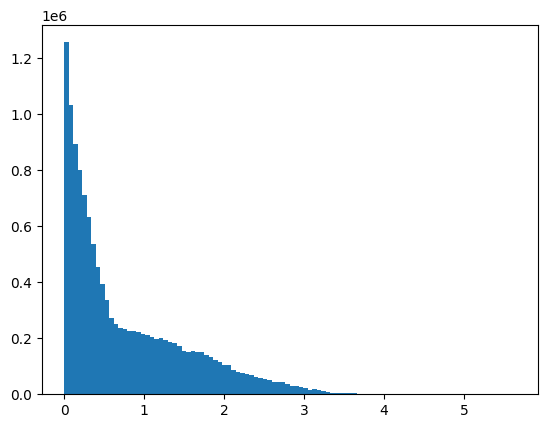

In [71]:
depth_np = np.array(depth_list)
flat = depth_np.flatten()
nonzero = flat[flat>1e-3]
print(np.mean(flat), np.std(flat), np.median(flat), np.max(flat), np.min(flat))
print(np.mean(nonzero), np.std(nonzero), np.median(nonzero), np.max(nonzero), np.min(nonzero))
rm = flat/(np.mean(flat)+3*np.std(flat))
plt.hist(rm[rm>1e-3], bins=100);

scale_dep = 1/(np.mean(flat)+3*np.std(flat))

In [110]:
combined_list = []
thresholded_list = []
output_list_scaled = []
BIAS = 0.9

for frame in range(len(attention_list)):
    attention_nm = attention_list[frame]*scale_att
    depth_nm = depth_list[frame]*scale_dep
    global BIAS
    global SCALE
    depth_re = cv2.resize(depth_nm, dsize=(16*SCALE, 9*SCALE), interpolation=cv2.INTER_CUBIC)
    attention_re = cv2.resize(attention_nm, dsize=(16*SCALE, 9*SCALE), interpolation=cv2.INTER_CUBIC)

    # combined = ((1-BIAS)*depth_re + (BIAS)*attention_re)
    combined = depth_re*attention_re
    # combined = cv2.normalize(combined, None, 0, 1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_64F)
    thresholded = (combined > THRESHOLD_VAL) * combined
    combined_list.append(combined)
    thresholded_list.append(thresholded)

    ### new code for interpolation:
    downsampled = np.zeros((DISPLAY_H, DISPLAY_W))
    interval_H = int(np.floor(thresholded.shape[0]/DISPLAY_H))
    interval_W = int(np.floor(thresholded.shape[1]/DISPLAY_W))
    for rr in range(0, DISPLAY_H):
        for cc in range(0, DISPLAY_W):
            frame_slice = thresholded[rr*interval_H:(rr+1)*interval_H, cc*interval_W:(cc+1)*interval_W]
            mean_slice = np.mean(frame_slice)
            std_slice = np.std(frame_slice)
            max_slice = np.max(frame_slice)
            if mean_slice+3*std_slice > max_slice: # I'm doing some weird selection of max vs. mean depending on std of the frame slice
                downsampled[rr, cc] = max_slice
            else:
                downsampled[rr, cc] = mean_slice

    output_list_scaled.append(downsampled)

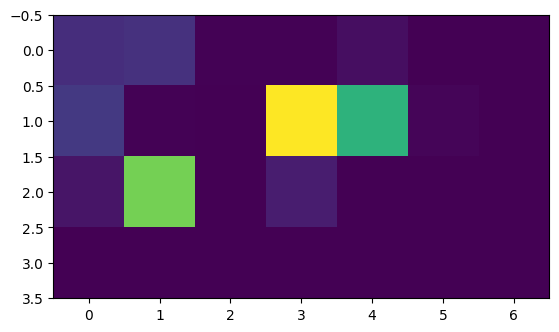

In [112]:
plt.imshow(output_list_scaled[200])
# plt.imshow(combined_list[200])
# plt.imshow(depth_list[200])
# plt.imshow(attention_list[200])

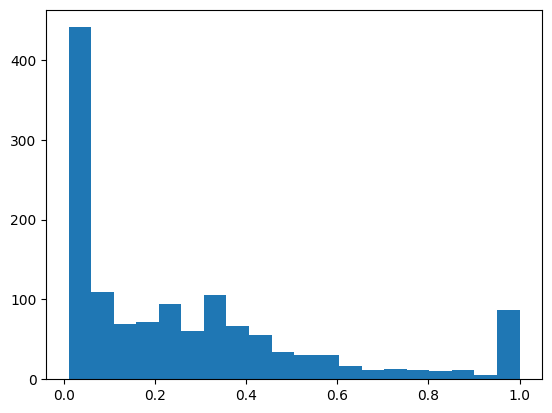

In [121]:
output_np = np.array(output_list_scaled)
flat = output_np.flatten()
nonzero = flat[flat>1e-3]
# plt.hist(nonzero, bins=100);

max_thresh = (np.mean(flat)+5*np.std(flat))
output_np[output_np>max_thresh] = max_thresh
scale_output = 1/(max_thresh)
output_scale = output_np*scale_output
flat2= output_scale.flatten()
plt.hist(flat2[flat2>1e-2], bins=20);